# Latent Space Approaches to Social Network Analysis

## Introduction

In the study of historical social networks, the relationships between influential families provide valuable insights into power dynamics, alliances, and social structures. One such case is the analysis conducted by Padgett and Ansell (1993), which examines marriage and business ties among 16 historically prominent Florentine families during the 15th century. Their work is based on historical accounts, particularly the research of Kent (1978), which documents the socio-political landscape of Renaissance Florence.

This notebook focuses specifically on the marriage relations between these families. In this dataset, a tie exists between two families if at least one marriage occurred between them. The relationship is undirected, as the records do not specify the respective families of the husband and wife. Notably, one of the 16 families had no marriage ties to others and was consequently excluded from the analysis. Including this family would result in an infinite distance in a maximum likelihood estimation and a large but finite distance in a Bayesian framework. By modeling these marriage relations using network analysis techniques, we can explore the structural properties of the Florentine elite and their strategic matrimonial alliances. This analysis provides a deeper understanding of the role of marriage in shaping political and economic power during the Renaissance. This work is inspired and replicated according the article of Hoff 2002 (consult [1]).

We are going to use the following libraries:

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from Modules.EuclideanM import *
from Modules.EuclideanV import *
from Modules.EuclideanC import *

## Florentine Families Network

The graph of the Florentine families is presented in the following plot.

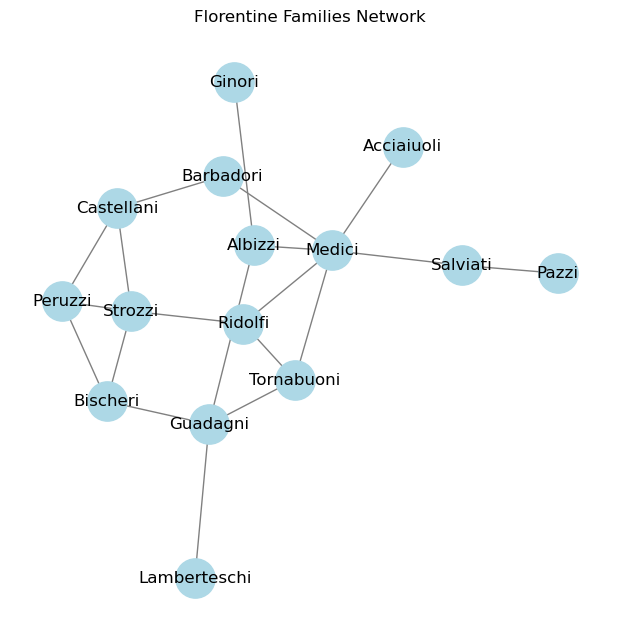

In [2]:
G = nx.florentine_families_graph()

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network")
plt.show()


It is important to reindex with integer number the previous network in order to deal with nodes and edges easily.

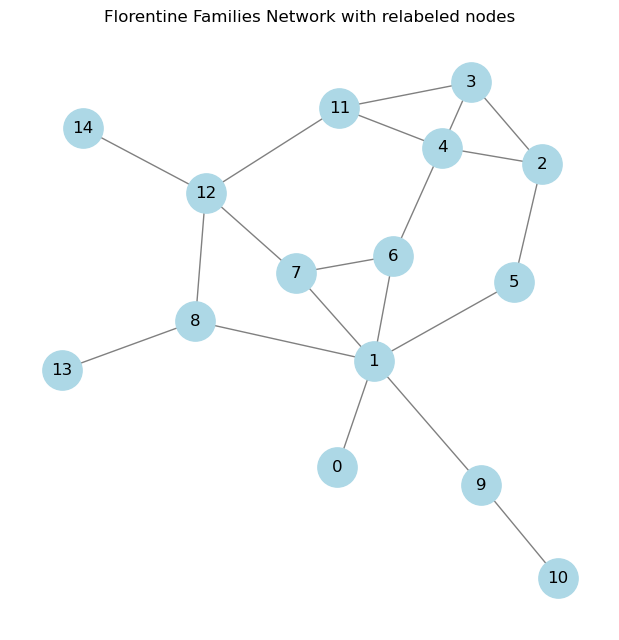

Map from original nodes to new nodes:
{'Acciaiuoli': 0, 'Medici': 1, 'Castellani': 2, 'Peruzzi': 3, 'Strozzi': 4, 'Barbadori': 5, 'Ridolfi': 6, 'Tornabuoni': 7, 'Albizzi': 8, 'Salviati': 9, 'Pazzi': 10, 'Bischeri': 11, 'Guadagni': 12, 'Ginori': 13, 'Lamberteschi': 14}


In [3]:
G = nx.florentine_families_graph()
node_mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, node_mapping)

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network with relabeled nodes")
plt.show()
print("Map from original nodes to new nodes:")
print(node_mapping)

The sociomatrix $Y$ or adjacency matrix is calculated in the following code.

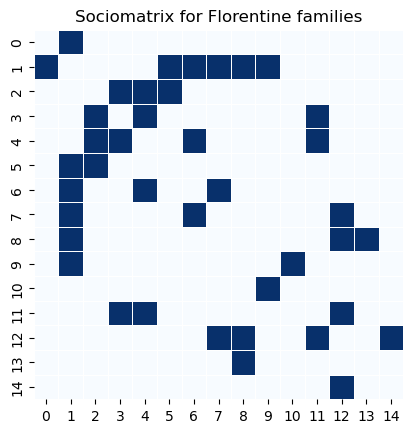

In [4]:
Y = nx.to_numpy_array(G, dtype=float)

sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Sociomatrix for Florentine families")
plt.show()

## Latent Space

To start the latent space model, the number of nodes $n$ in the graph is calculated and the latent variables are randomly initialized with sampling from a normal standard distribution a matrix of size $n\times 2$ since we are representing our network in a $2$-dimensional space.

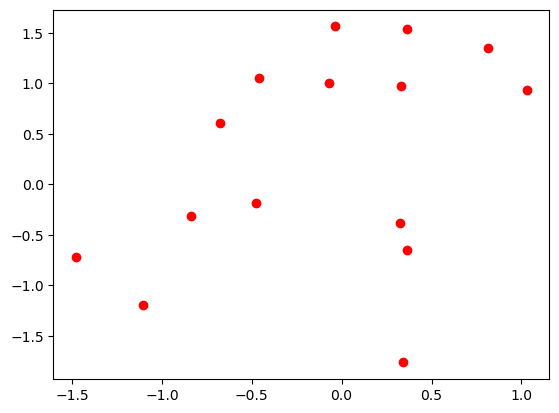

In [5]:
n = len(G.nodes)

Z = np.random.randn(n, 2)
plt.plot(Z[:,0],Z[:,1], 'ro')
plt.show()

## Likelihood

In order to calculate the probability to have a tie between two nodes given the latent variables and its properties, the following model is proposed:


$$\eta_{ij} := logit(\mathbb{P}(y_{ij}=1\ |\ z_i,z_j,a)) = a -d_{ij},$$

equivalently,

$$\mu_{ij} := \mathbb{P}(y_{ij}=1\ |\ z_i,z_j,a) = expit(a (1-d_{ij})) = \frac{1}{1+\exp{(-a(1-d_{ij}))}},$$

where $d_{ij}$ measures the distance between the two latent variables in the next way,

$$d_{ij} = \frac{1}{2}\|z_i-z_j\|^2.$$

Since $y_{ij}\in\{0,1\}$ and we suppose that the conection bewteen edges are independente, then the likelihood is given by the expression

$$L(\eta) = \mathbb{P}(Y\ |\ \eta) = \prod_{i\not=j} \mu_{ij}^{y_{ij}}(1-\mu_{ij})^{1-y_{ij}},$$


and the log-likelihood

$$\ell(\eta) = \log(\mathbb{P}(Y\ |\ \eta)) = \sum_{i\not=j} \eta_{ij}y_{ij} - \log(1+e^{\eta_{ij}}),$$

with its respective derivatives,


$$\frac{\partial}{\partial z_{k}} \ell(\eta) = \sum_{i\not=k} a (z_k-z_i)\left(expit(\eta_{ki})- y_{ki}\right),$$

$$\frac{\partial}{\partial a} \ell(\eta) =  \sum_{i\not=j} -(1-d_{ij})\left(expit(\eta_{ki})- y_{ki}\right).$$

### Searching MLE

For searching the maximum likelihood estimation, we search the maximum of the loglikelihood function through gradient descent with line search.

Loglikelihood: -46.593738804138674


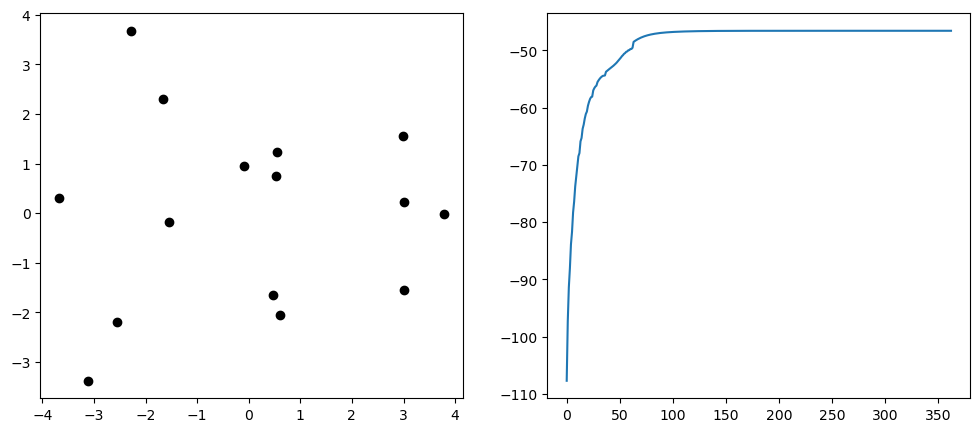

In [6]:
Z_ML, a_ML, historyZ, historya  =  SearchingMLE(G, np.random.randn(n, 2),np.random.randn(),10000)
Z_ML = Z_ML - np.mean(Z_ML, axis=0)

print("Loglikelihood:", loglikelihood(G, Z_ML,a_ML))

fig, ax = plt.subplots(1,2,figsize = (12,5))
ax[0].plot(Z_ML[:,0],Z_ML[:,1], 'ko')
ax[1].plot([loglikelihood(G, historyZ[t],historya[t]) for t in range(len(historya))])
plt.show()

### Sociomatrix

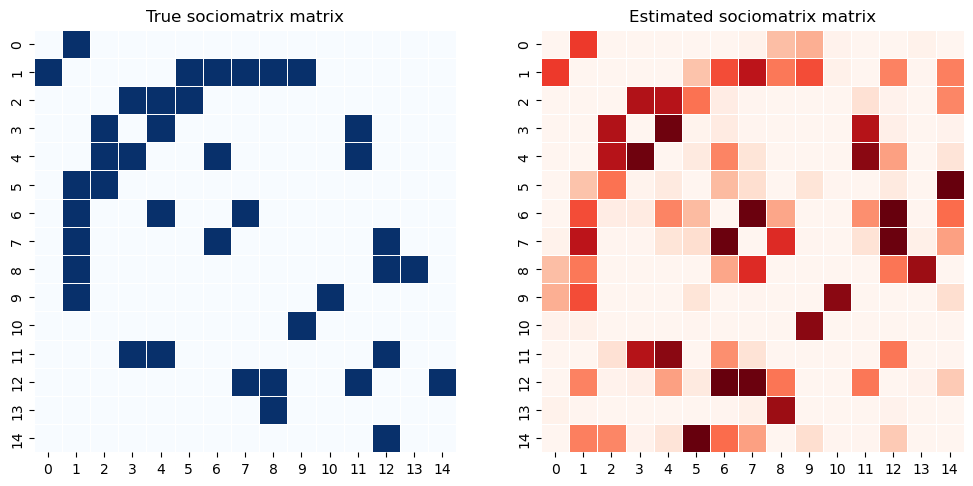

In [7]:
Y_ML = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y_ML[i,j] = expit(a_ML - 0.5 * np.linalg.norm(Z_ML[i] - Z_ML[j])**2)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(1,2,2)
sns.heatmap(Y_ML, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Estimated sociomatrix matrix")
plt.show()

## Applying Hamiltonian Monte Carlo Algorithm

In [8]:
# Execute HMC
number_of_samples = 20000
Z_init = np.random.randn(Z_ML.shape[0],Z_ML.shape[1])
a_init = np.random.randn(1)

print("Log-L MLE:", loglikelihood(G,Z_ML,a_ML))
print("Log-L starter:", loglikelihood(G,Z_init,a_init)[0])

samples_Z, samples_a, Hp, LogLp, acep_rate_history = hmc(G, Z_init, a_init, number_of_samples, 
                                                         epsilon_init=0.15, std_dev=1.0, percentage_warmup=0.1, Z0 = Z_ML)

# Estimators
## CM
Z_CM =  np.mean(samples_Z, axis=0)
a_CM = np.mean(samples_a, axis=0)
## MAP
Z_MAP = samples_Z[np.argmin(Hp),:,:]
a_MAP = samples_a[np.argmin(Hp)]


print("Log-L MAP:", loglikelihood(G,Z_MAP,a_MAP))
print("Log-L CM:", loglikelihood(G,Z_CM,a_CM))

Log-L MLE: -46.593738804138674
Log-L starter: -182.9091625572151
Number of samples: 20000
Number of parameters: 16
Number of iterations: 22000
Number of warmup iterations: 2000


  9%|▉         | 2000/22000 [16:31<3:13:58,  1.72it/s]

Final parameters: epsilon=0.0500, L=20, std_dev=0.0500


100%|██████████| 22000/22000 [2:29:06<00:00,  2.46it/s]  


Acceptance rate: 0.07900
Log-L MAP: -57.02999933932714
Log-L CM: -59.32977332085951


# Results 

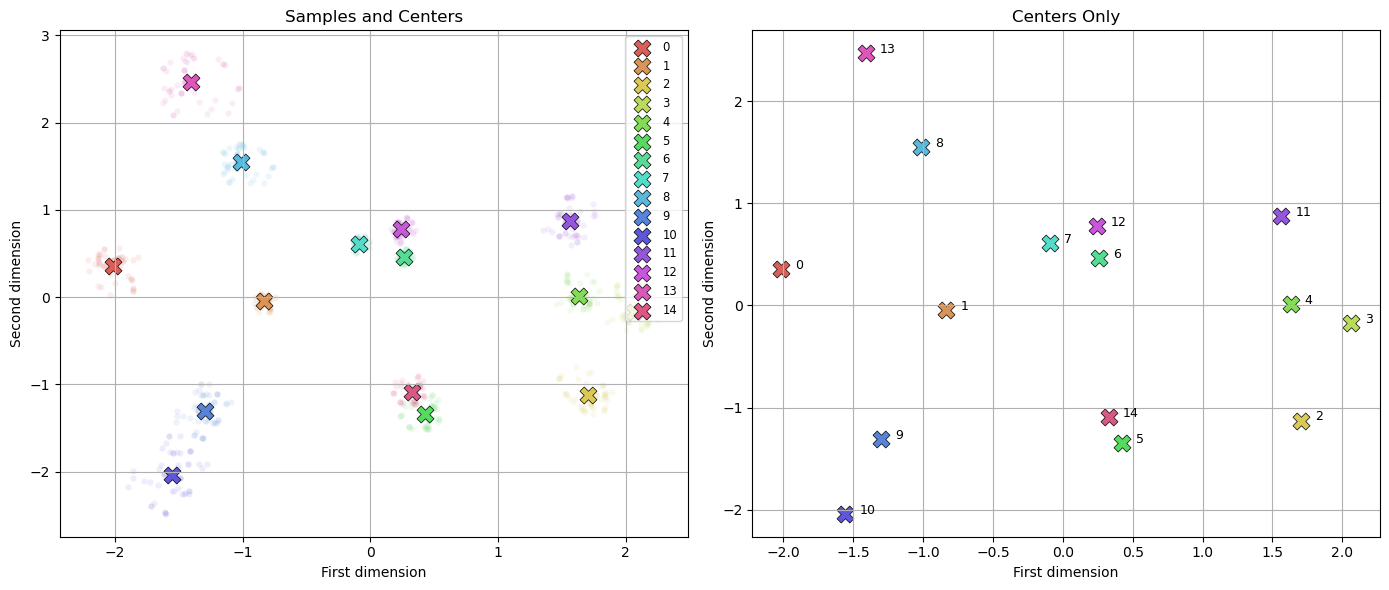

In [9]:
plot_Z_samples_2D(samples_Z[-50:])

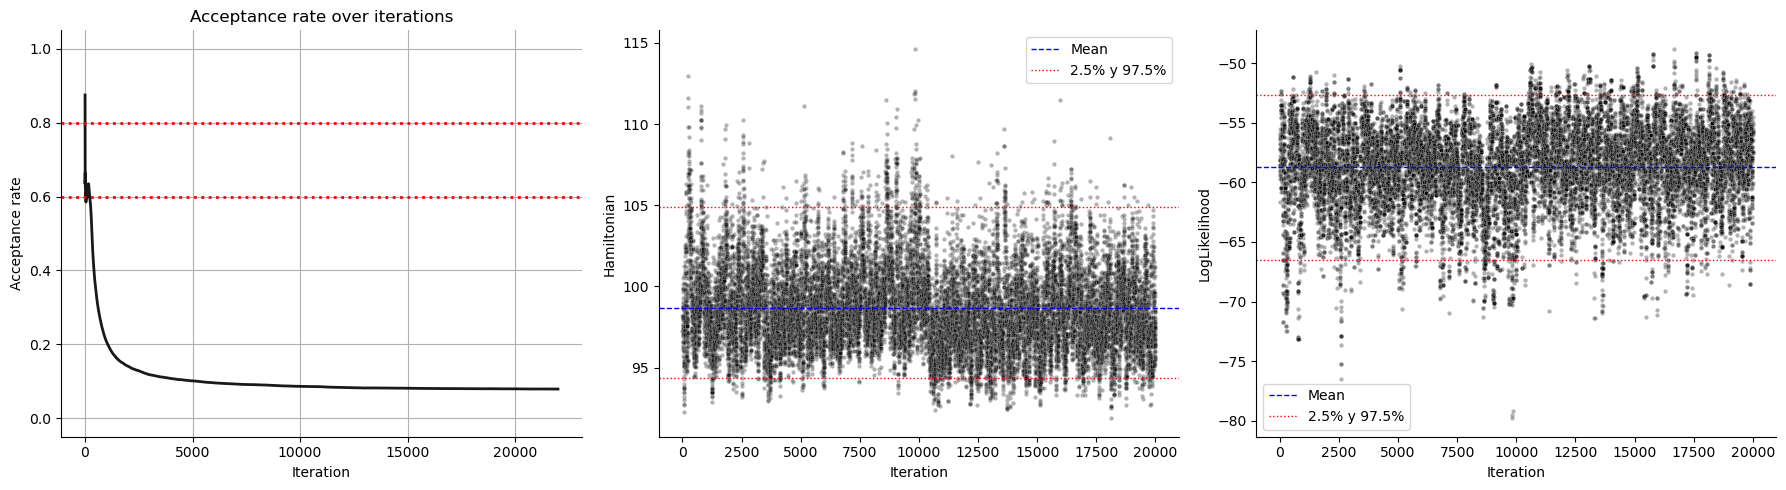

In [10]:
plot_diagnostics(Hp,LogLp,acep_rate_history)

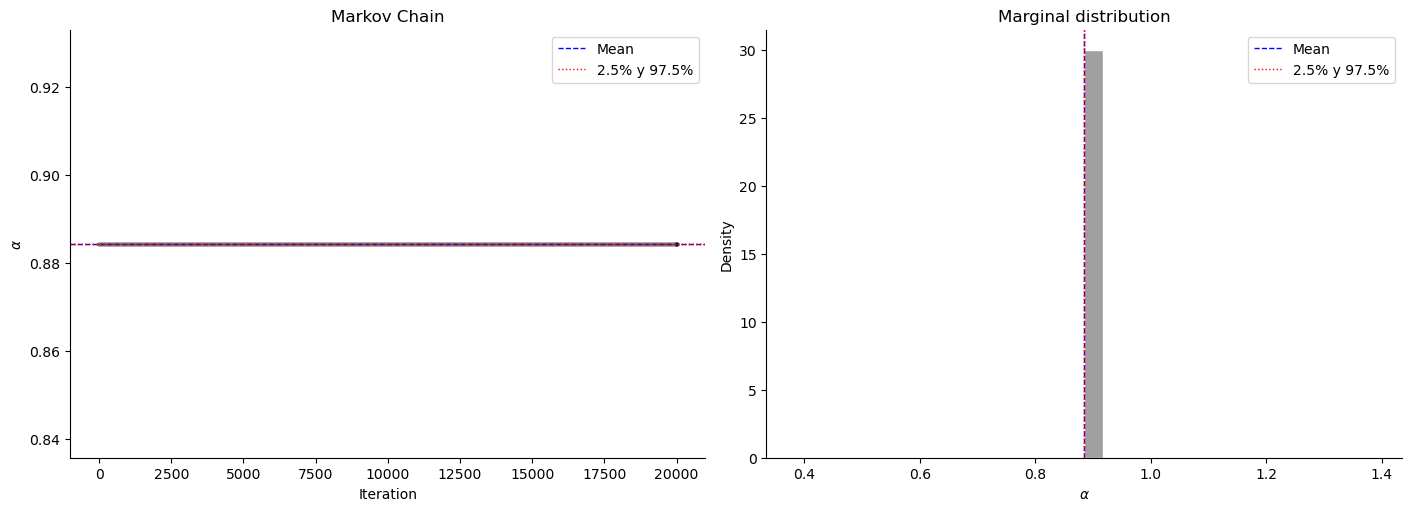

In [11]:
plot_alpha(samples_a)

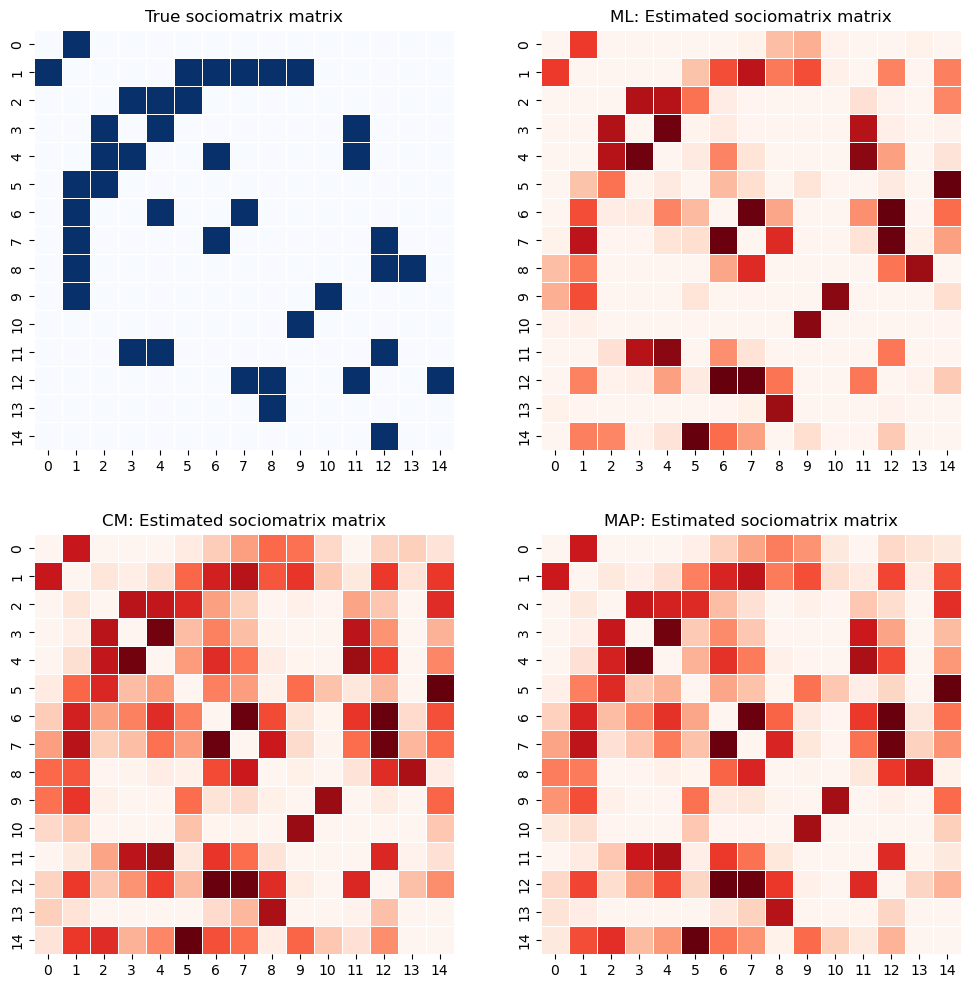

In [12]:
Y_CM = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y_CM[i,j] = expit(a_CM - 0.5 * np.linalg.norm(Z_CM[i] - Z_CM[j])**2)

Y_MAP = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y_MAP[i,j] = expit(a_MAP - 0.5 * np.linalg.norm(Z_MAP[i] - Z_MAP[j])**2)

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(2,2,2)
sns.heatmap(Y_ML, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("ML: Estimated sociomatrix matrix")
plt.subplot(2,2,3)
sns.heatmap(Y_CM, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("CM: Estimated sociomatrix matrix")
plt.subplot(2,2,4)
sns.heatmap(Y_MAP, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("MAP: Estimated sociomatrix matrix")
plt.show()

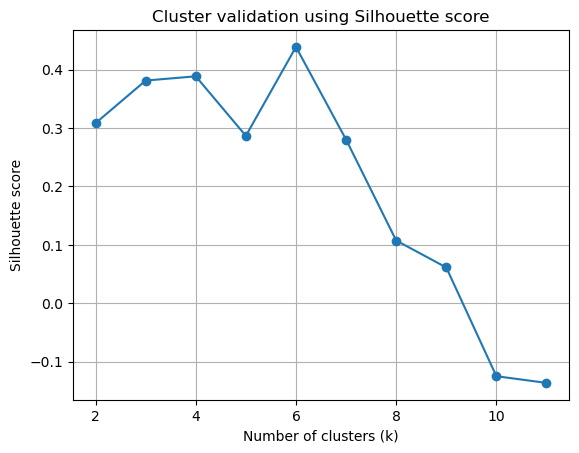

Best number of clusters: 6


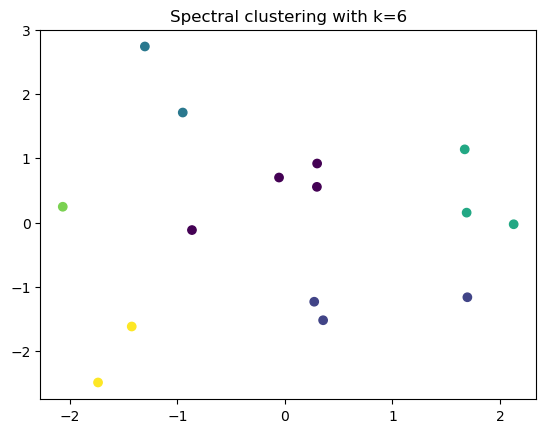

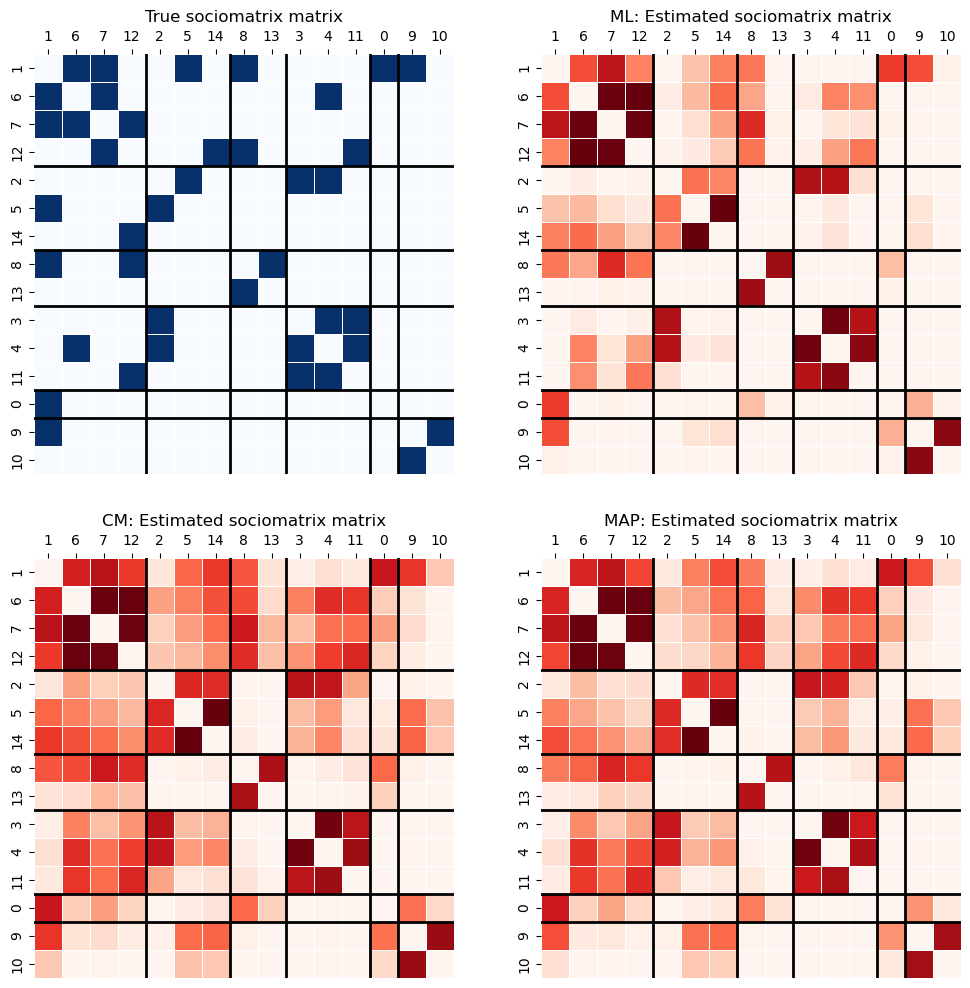

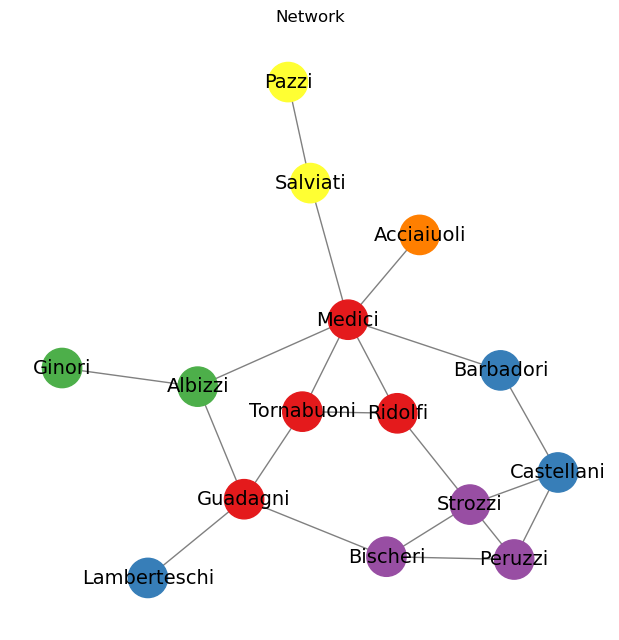

In [13]:
clustering2D(G,node_mapping, Z_ML, a_ML, Z_MAP, a_MAP, Z_CM, a_CM)

# Model checking

## Posterior predictive checking

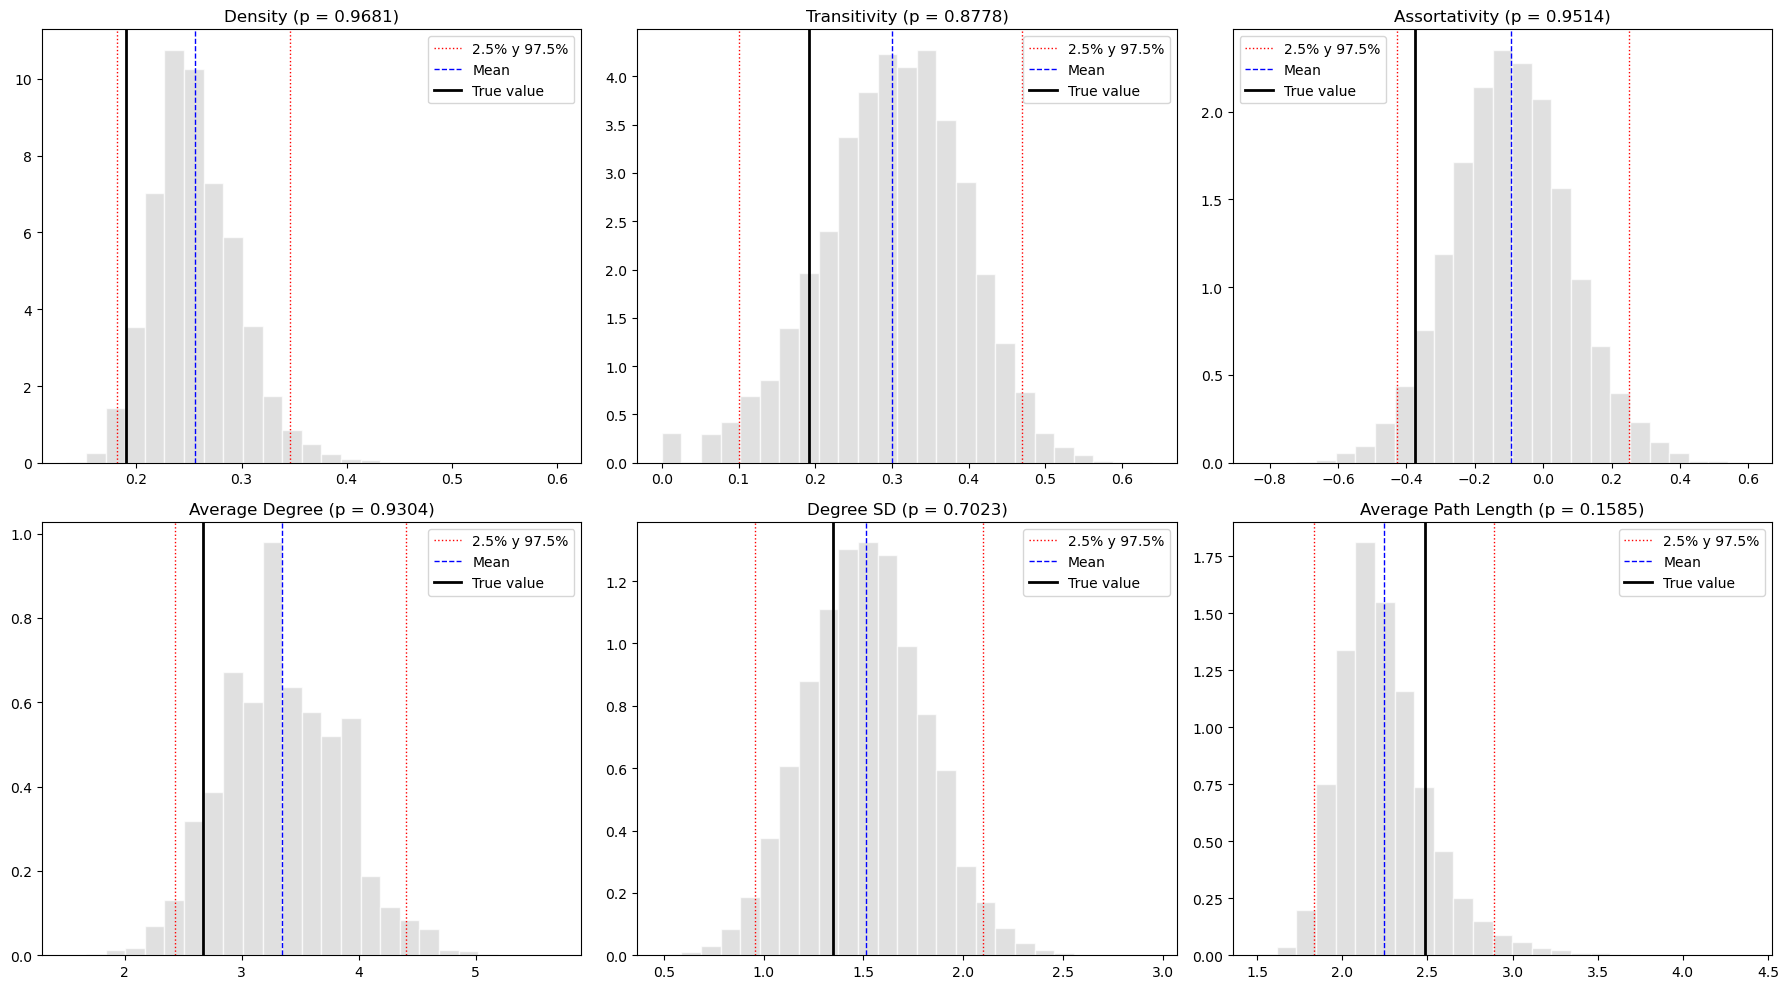

In [14]:
predictive_check(G,samples_Z,samples_a)

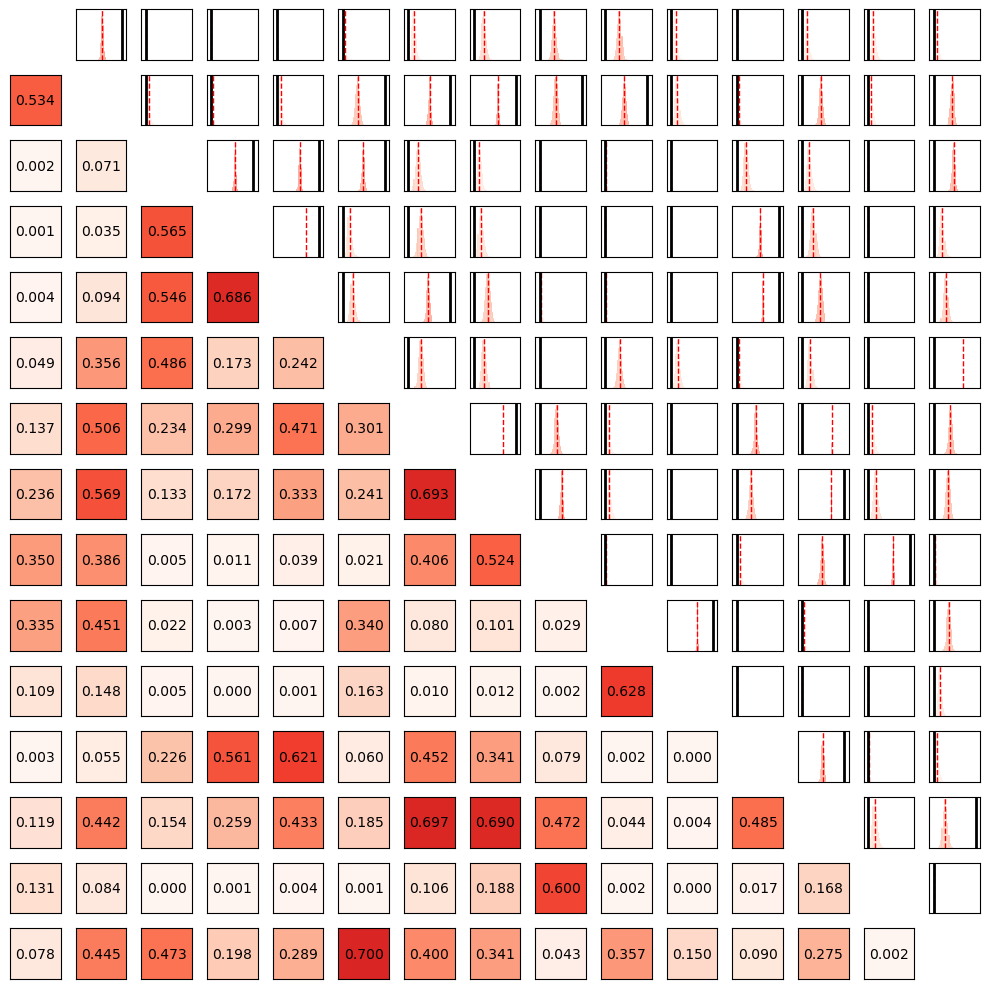

In [15]:
plot_pairwise_sociomatrix(G,samples_Z, samples_a, Y)

## Model comparison criteria

In [16]:
log_lik = compute_log_likelihood(Y, samples_Z, samples_a)
waic = compute_WAIC(log_lik)
dic = compute_DIC(log_lik, Y, samples_Z, samples_a)


print(f"WAIC: {waic:.4f}")
print(f"DIC: {dic:.4f}")


WAIC: 120.8319
DIC: 121.6131


## Prior predictive checks

In [17]:
samples_Z_prior = 0.1*np.random.randn(number_of_samples, n, 2)
samples_a_prior = np.random.randn(number_of_samples)

c:\Users\carlo\anaconda3\Lib\site-packages\networkx\algorithms\assortativity\correlation.py:298: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
c:\Users\carlo\anaconda3\Lib\site-packages\networkx\algorithms\assortativity\mixing.py:207: RuntimeWarning: invalid value encountered in divide
  a = a / a.sum()


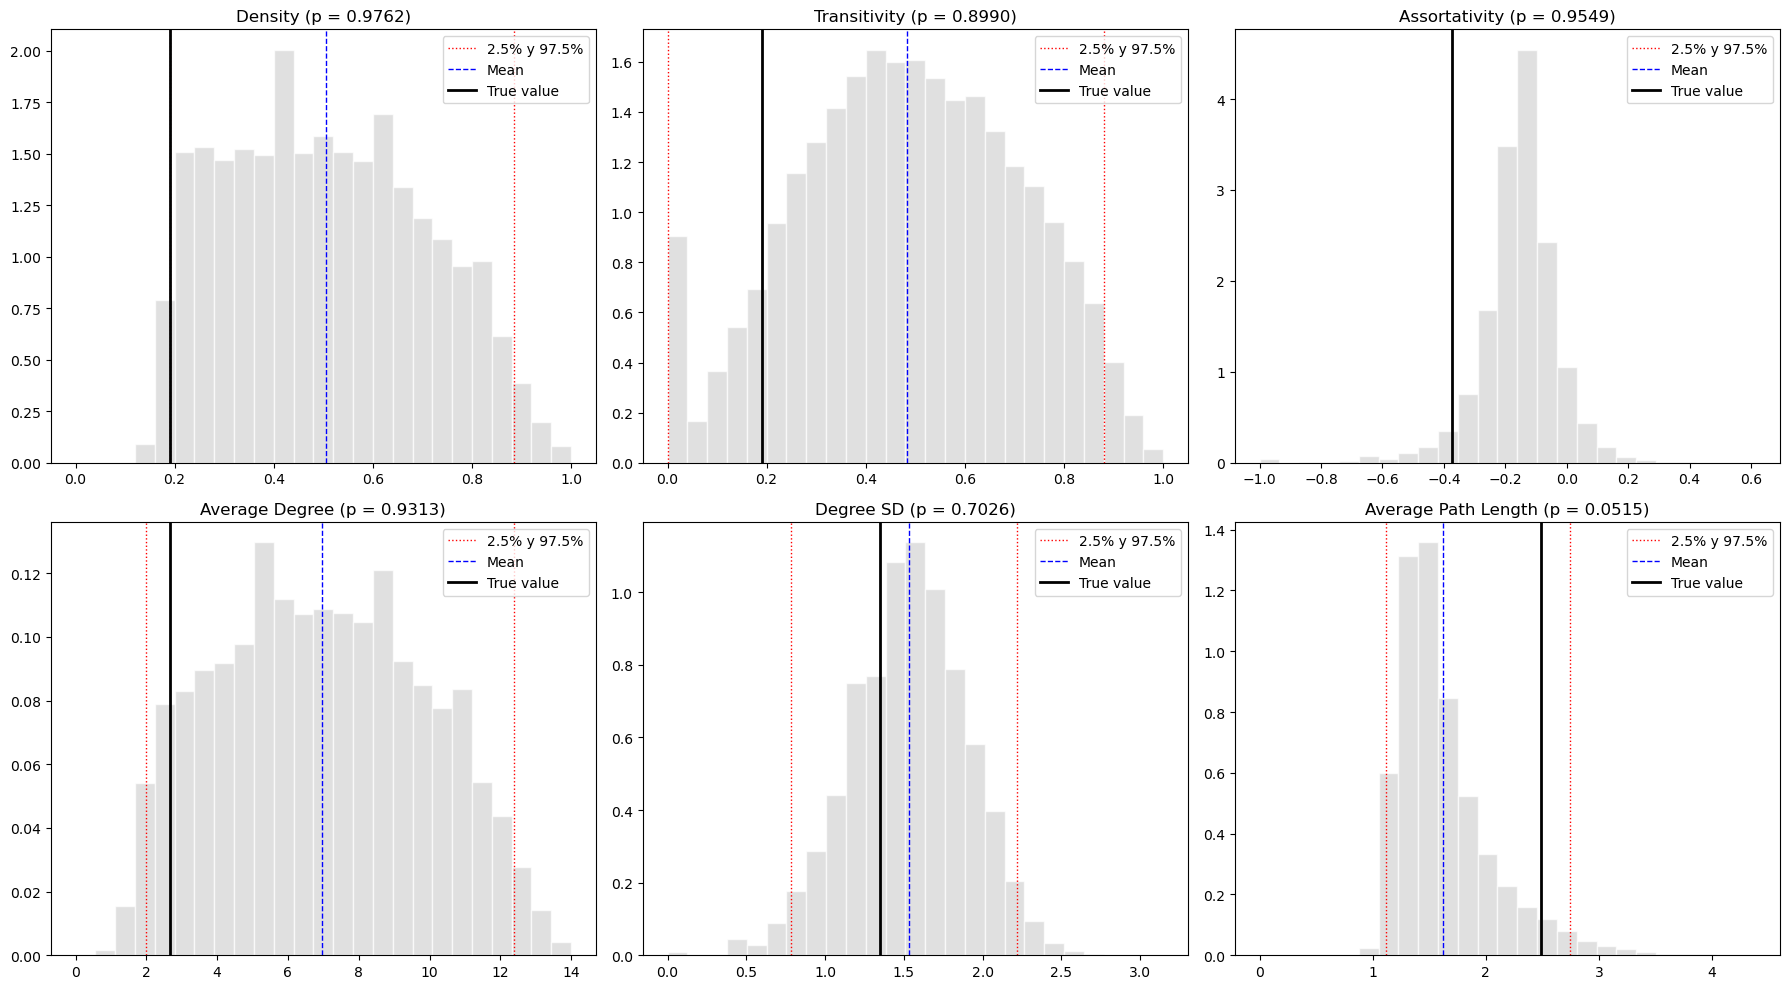

In [18]:
predictive_check(G,samples_Z_prior,samples_a_prior)

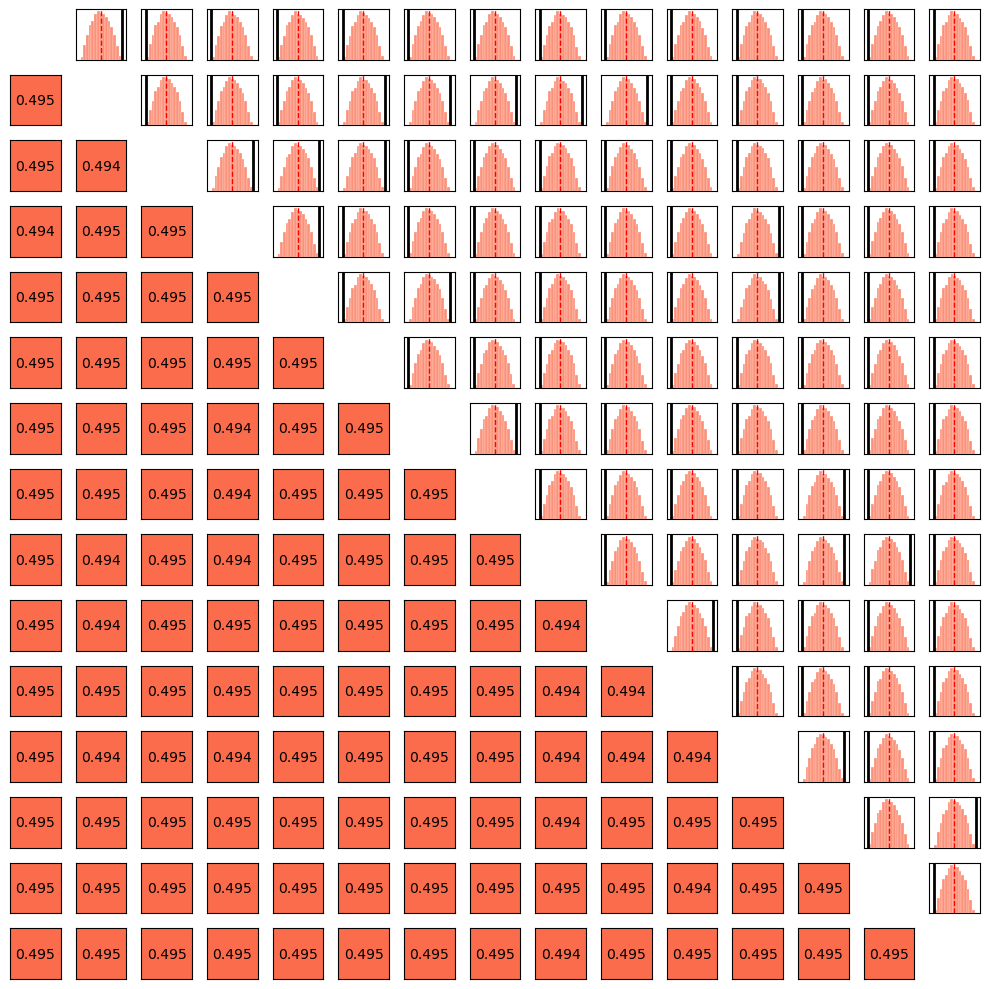

In [19]:
plot_pairwise_sociomatrix(G,samples_Z_prior, samples_a_prior, Y)

In [20]:
log_lik_prior = compute_log_likelihood(Y_ML, samples_Z_prior, samples_a_prior)
waic_prior = compute_WAIC(log_lik_prior)
dic_prior = compute_DIC(log_lik_prior, Y_ML, samples_Z_prior, samples_a_prior)


print(f"WAIC: {waic_prior:.4f}")
print(f"DIC: {dic_prior:.4f}")

WAIC: 398.2845
DIC: 375.7803


## Residual analysis

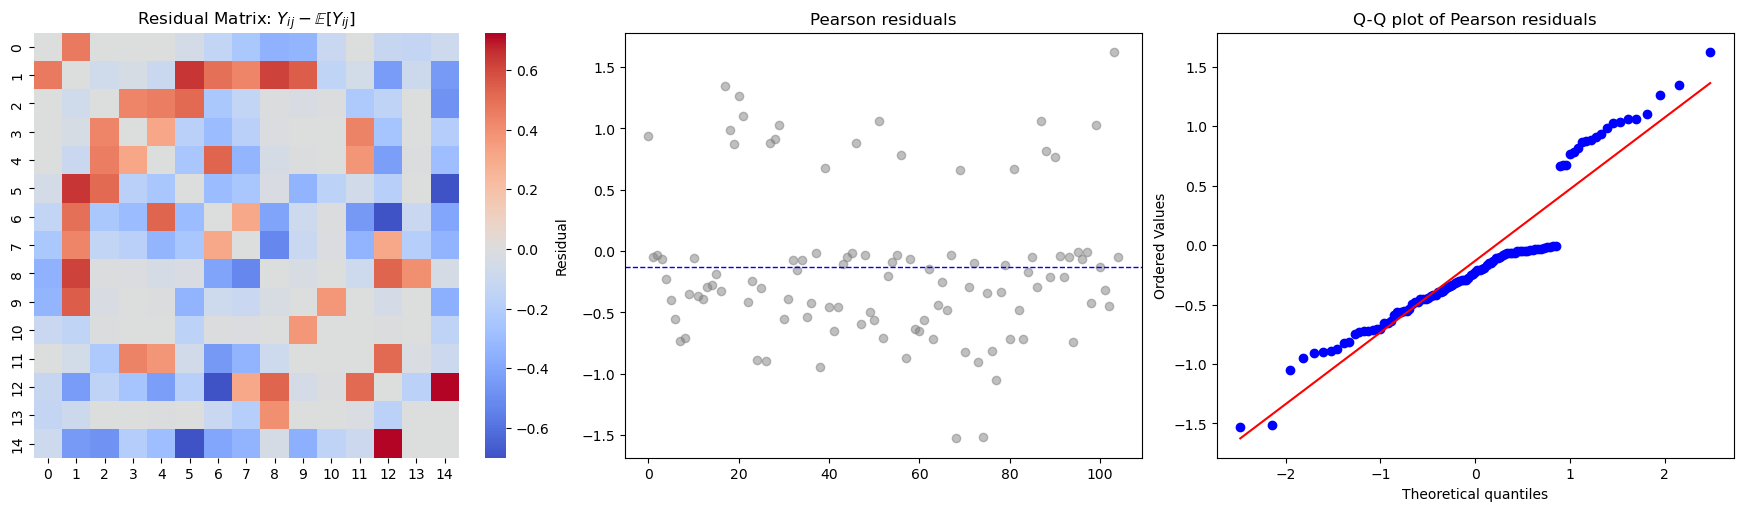

In [21]:
residuals = residual_analysis(Y, samples_Z, samples_a)

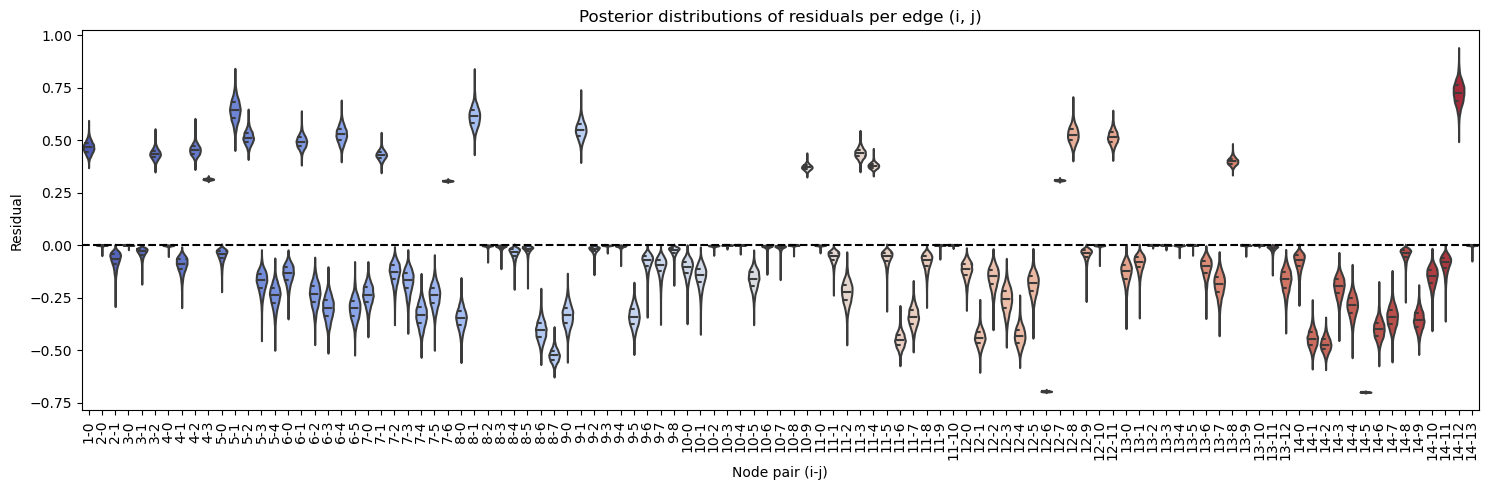

In [22]:
residuals_dict = residual_distributions(Y, samples_Z, samples_a)
plot_residual_distributions(residuals_dict, n)

In [23]:
residual_summary = summarize_residuals_bayesian(residuals_dict)
residual_summary

,pair,mean,std,z_score,ci_lower,ci_upper,bayes_p
0,1-0,0.466315,0.028747,16.221284,0.413278,0.524103,1.0
1,2-0,-0.002304,0.003088,-0.746118,-0.010997,-0.000110,0.0
2,2-1,-0.070875,0.036566,-1.938298,-0.160276,-0.020859,0.0
3,3-0,-0.000930,0.001417,-0.656398,-0.004732,-0.000035,0.0
4,3-1,-0.034822,0.021210,-1.641721,-0.089375,-0.008426,0.0
...,...,...,...,...,...,...,...
100,14-9,-0.356607,0.046066,-7.741193,-0.447985,-0.265148,0.0
101,14-10,-0.150014,0.046461,-3.228800,-0.252691,-0.073225,0.0
102,14-11,-0.089810,0.041613,-2.158222,-0.191815,-0.031770,0.0
103,14-12,0.725304,0.053929,13.449334,0.617984,0.829205,1.0


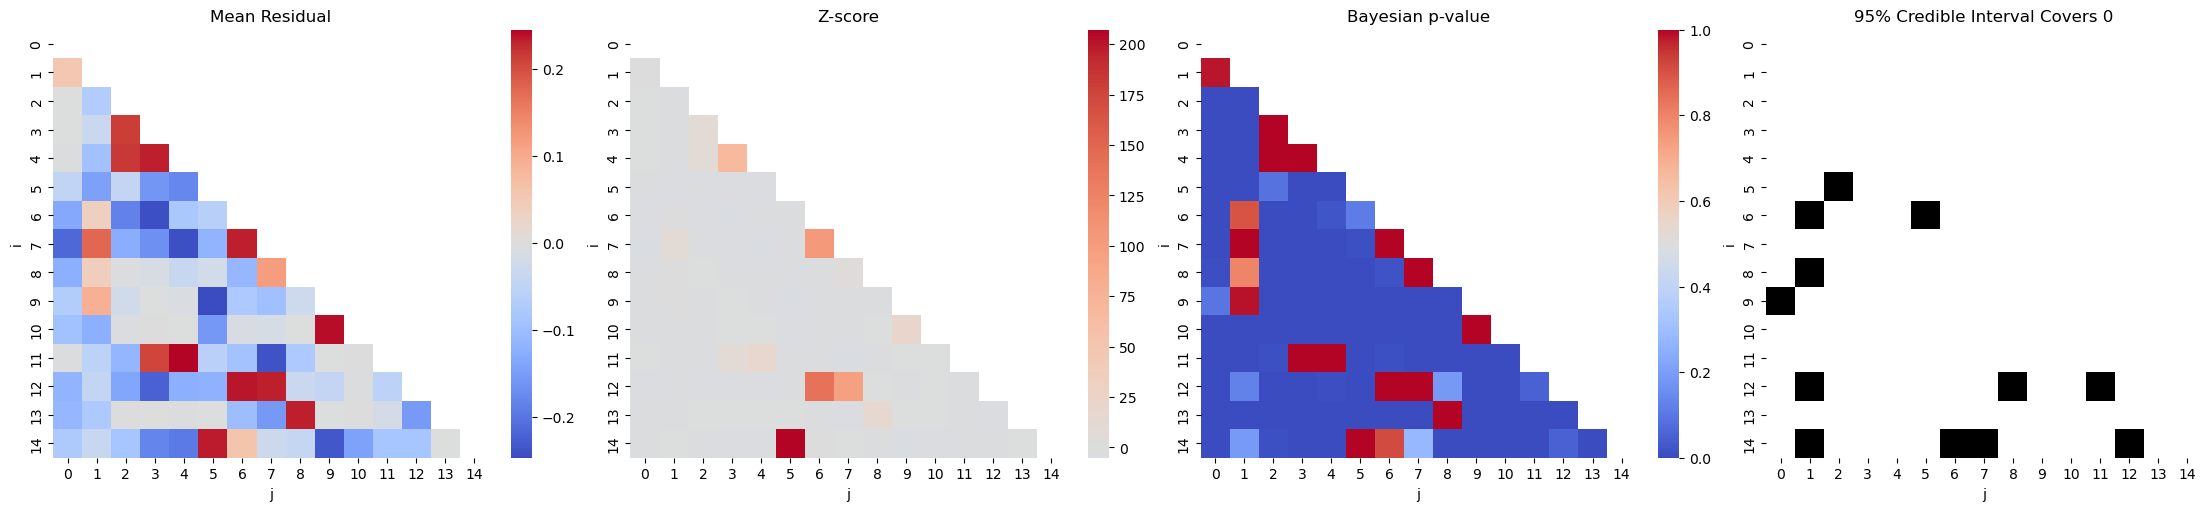

In [24]:
residuals_dict = residual_distributions(Y_ML, samples_Z, samples_a)
summary_matrices = analyze_residuals_matrix(residuals_dict, Y_ML.shape[0])
plot_residual_summary_matrices(summary_matrices)

## Prediction evaluation

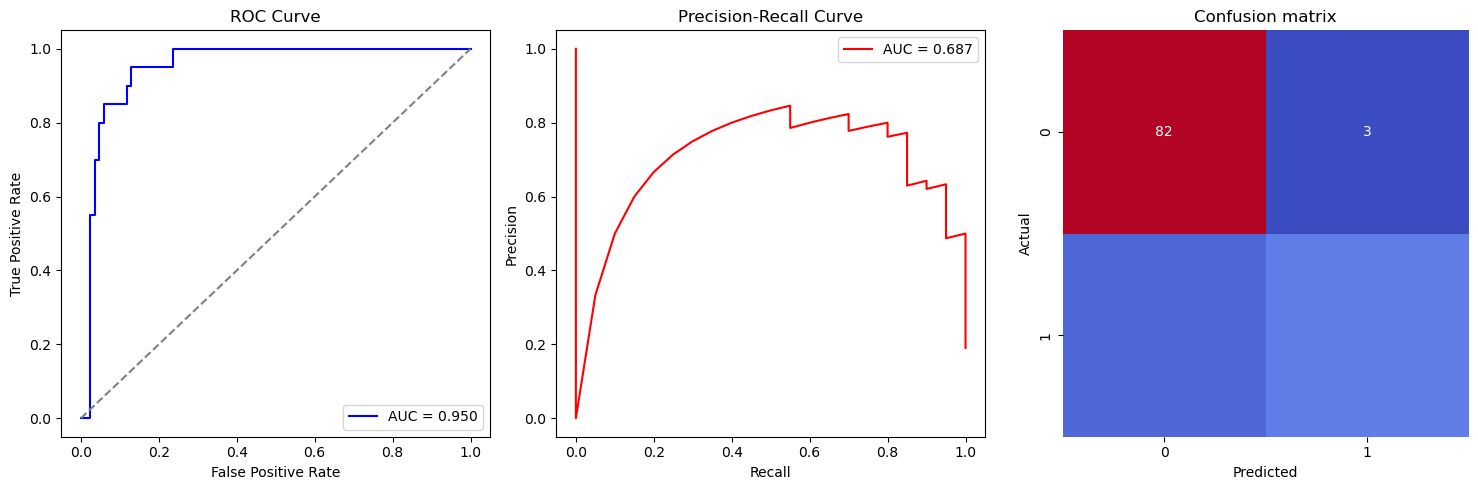

In [25]:
prob_mean = posterior_connection_probs(samples_Z, samples_a)
metrics = roc_prc_analysis(Y, prob_mean)


## Community checking

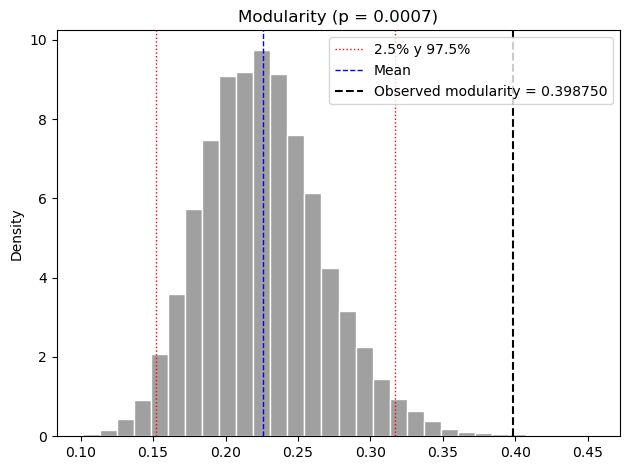

In [26]:
mod_obs, mod_sim = modularity_check(Y, samples_Z, samples_a)

## References

[1] Hoff, P. D., Raftery, A. E., & Handcock, M. S. (2002). Latent space approaches to social network analysis. Journal of the American Statistical Association, 97(460), 1090-1098. https://doi.org/10.1198/016214502388618906